This implementaion will use LTSM to predict stock prices. Our goal is to predict the price of Nvidia(NVDA) stock prices for the period 25 Oct to 7 Nov, which is exactly 10 days. 


In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

stock_data = pd.read_csv("NVDA.csv")
stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1252,2023-10-17,440.000000,447.540009,424.799988,439.380005,439.380005,81233300
1253,2023-10-18,425.910004,432.190002,418.250000,421.959991,421.959991,62729400
1254,2023-10-19,428.109985,432.970001,418.820007,421.010010,421.010010,50123300
1255,2023-10-20,418.899994,424.700012,410.779999,413.869995,413.869995,47638100
1256,2023-10-23,412.290009,432.480011,409.450012,429.750000,429.750000,47721800


In [2]:
# check if any row or column contains invalid values
stock_data.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

We will try to see the graph of the historical closing prices against time.

In [3]:
stock_data.loc[:, ['Date', 'Close']]

,Date,Close
0,2018-10-24,49.852501
1,2018-10-25,51.959999
2,2018-10-26,49.572498
3,2018-10-29,46.404999
4,2018-10-30,50.750000
...,...,...
1252,2023-10-17,439.380005
1253,2023-10-18,421.959991
1254,2023-10-19,421.010010
1255,2023-10-20,413.869995


Text(0, 0.5, 'Prices ($)')

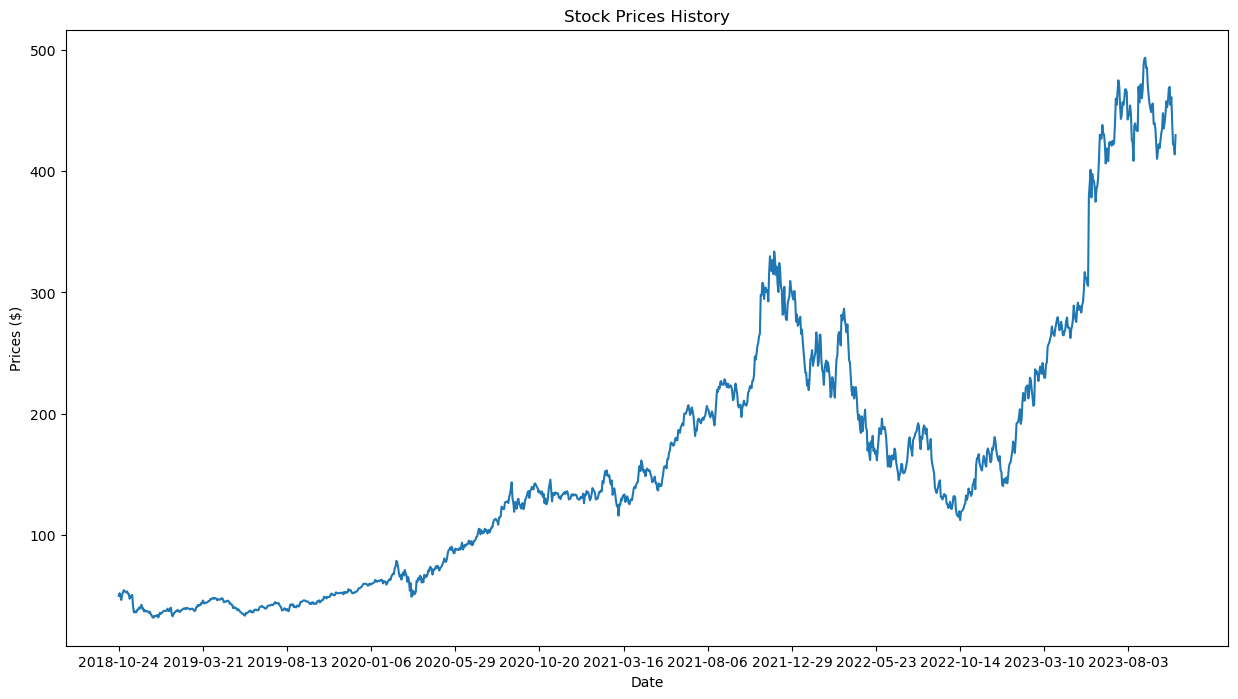

In [4]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data.loc[:, 'Date'], stock_data.loc[: , 'Close'])
plt.xticks(np.arange(0,1230,100))
plt.xlabel('Date')
plt.ylabel('Prices ($)')


We will first split the data into training and testing sets. Then attempt to normalise the data to the range of 0 to 1.

In [5]:
# We set the training set size to be 80% of total dataset
training_data_len = math.ceil(len(stock_data)* 0.8)
training_set = stock_data[['Close']].iloc[:training_data_len].values
test_set = stock_data[['Close']].iloc[training_data_len-12:].values

# Use the MinMaxScaler function to scale the training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_training_set = scaler.fit_transform(training_set)

# Create a 12-days window of historical prices (i-12) as our feature data
# (x_train) and the following 12-days window as label data (y_train)
X_train = []
y_train = []

for i in range(12, training_data_len):
  X_train.append(scaled_training_set[i-12:i, 0])
  y_train.append(scaled_training_set[i, 0])

# convert array into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)
# reshape X to the format (values, time-steps, 1 dimensional output)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Now we will start building the model. We will build the LSTM with 100 neurons and 4 hidden layers. Finally, we will assign 1 neuron in the output layer for predicting the normalized stock price. We will use the RMSE loss function and the Adam stochastic gradient descent optimizer.

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True,
               input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
# Adding a dense layer
model.add(layers.Dense(25))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 20)

Epoch 1/150
50/50 [==============================] - 9s 26ms/step - loss: 0.0183
Epoch 2/150
50/50 [==============================] - 1s 23ms/step - loss: 0.0033
Epoch 3/150
50/50 [==============================] - 1s 23ms/step - loss: 0.0035
Epoch 4/150
50/50 [==============================] - 1s 25ms/step - loss: 0.0031
Epoch 5/150
50/50 [==============================] - 1s 22ms/step - loss: 0.0030
Epoch 6/150
50/50 [==============================] - 1s 26ms/step - loss: 0.0037
Epoch 7/150
50/50 [==============================] - 1s 21ms/step - loss: 0.0025
Epoch 8/150
50/50 [==============================] - 1s 25ms/step - loss: 0.0026
Epoch 9/150
50/50 [==============================] - 1s 22ms/step - loss: 0.0028
Epoch 10/150
50/50 [==============================] - 1s 25ms/step - loss: 0.0023
Epoch 11/150
50/50 [==============================] - 1s 22ms/step - loss: 0.0021
Epoch 12/150
50/50 [==============================] - 1s 24ms/step - loss: 0.0022
Epoch 13/150
50/50 [=====

Preparing the test set below.

In [7]:
# test set is the set we split at the start
scaled_test_set = scaler.fit_transform(test_set.reshape(-1, 1))

X_test = []
for i in range(12, len(scaled_test_set)):
    X_test.append(scaled_test_set[i-12:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(251, 12, 1)


Start predicting with the test set.

In [8]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 7ms/step


Now we shall visualise the result.

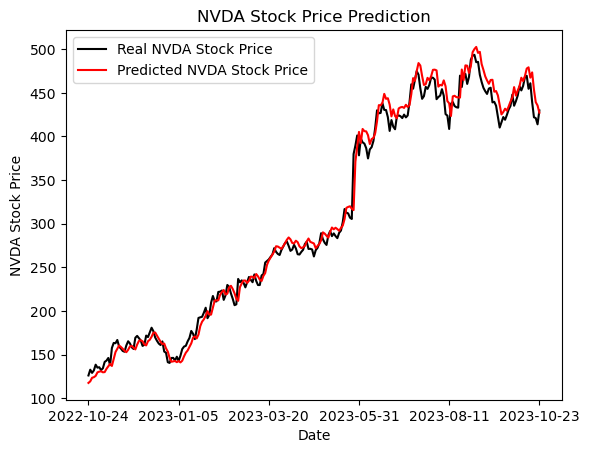

In [9]:
# Visualising the results
plt.plot(stock_data.loc[training_data_len:, 'Date'], test_set[12:, :], color = 'black', label = 'Real NVDA Stock Price')
plt.plot(stock_data.loc[training_data_len:, 'Date'], predicted_stock_price, color = 'red', label = 'Predicted NVDA Stock Price')
plt.xticks(np.arange(0,len(test_set)-12,50))
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()

### Model Evaluation
We will measure the root mean squared error of the predicted values against the actual values.

In [10]:
print(predicted_stock_price[:-12])
rmse = np.sqrt(np.mean(predicted_stock_price - test_set[12:, :])**2)
rmse

[[117.443726]
 [119.24632 ]
 [123.322266]
 [124.00033 ]
 [125.50652 ]
 [129.57181 ]
 [130.35342 ]
 [130.8104  ]
 [129.61249 ]
 [129.86662 ]
 [133.60408 ]
 [136.44188 ]
 [139.30878 ]
 [136.89648 ]
 [145.06264 ]
 [152.8315  ]
 [156.56683 ]
 [160.35478 ]
 [158.65485 ]
 [156.6016  ]
 [154.31071 ]
 [152.65967 ]
 [155.3609  ]
 [159.2438  ]
 [159.88148 ]
 [157.8209  ]
 [155.85754 ]
 [161.43309 ]
 [165.62341 ]
 [166.31378 ]
 [165.25533 ]
 [161.63567 ]
 [160.42122 ]
 [165.23172 ]
 [166.9085  ]
 [170.35883 ]
 [174.97746 ]
 [175.22815 ]
 [171.60518 ]
 [167.91466 ]
 [164.52623 ]
 [161.91862 ]
 [162.59937 ]
 [157.09688 ]
 [153.27156 ]
 [146.12083 ]
 [141.71577 ]
 [142.1882  ]
 [142.61723 ]
 [141.25082 ]
 [142.4951  ]
 [140.95636 ]
 [142.89413 ]
 [147.92854 ]
 [152.10149 ]
 [154.67691 ]
 [158.6324  ]
 [162.77756 ]
 [169.13338 ]
 [170.7689  ]
 [168.43433 ]
 [172.83319 ]
 [182.55125 ]
 [187.65486 ]
 [190.37666 ]
 [194.44461 ]
 [199.6734  ]
 [195.64641 ]
 [195.79129 ]
 [203.80879 ]
 [211.92438 ]
 [212.

3.5464699079930284

### Actual Prediction
The trained model seems to be performing reasonably well, so I will start training based on the whole dataset and predict the stock prices for the period 25 Oct to 7 Nov (10 days)
However, data on 24 Oct cannot be obatined since that will be after the submission deadline. Hence we will train for 12 days period and truncate it to the required 10 days period.

In [11]:
scaled_data = scaler.fit_transform(stock_data[['Close']].values)

X = []
y = []
for i in range(12, len(scaled_data)):
    X.append(scaled_data[i-12:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True,
               input_shape = (X.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
# Adding a dense layer
model.add(layers.Dense(25))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 20)


Epoch 1/200
50/50 [==============================] - 10s 23ms/step - loss: 0.0138
Epoch 2/200
50/50 [==============================] - 1s 27ms/step - loss: 0.0037
Epoch 3/200
50/50 [==============================] - 1s 23ms/step - loss: 0.0033
Epoch 4/200
50/50 [==============================] - 1s 25ms/step - loss: 0.0033
Epoch 5/200
50/50 [==============================] - 1s 25ms/step - loss: 0.0038
Epoch 6/200
50/50 [==============================] - 1s 25ms/step - loss: 0.0027
Epoch 7/200
50/50 [==============================] - 1s 25ms/step - loss: 0.0024
Epoch 8/200
50/50 [==============================] - 1s 23ms/step - loss: 0.0025
Epoch 9/200
50/50 [==============================] - 1s 23ms/step - loss: 0.0026
Epoch 10/200
50/50 [==============================] - 1s 26ms/step - loss: 0.0030
Epoch 11/200
50/50 [==============================] - 1s 22ms/step - loss: 0.0022
Epoch 12/200
50/50 [==============================] - 1s 24ms/step - loss: 0.0025
Epoch 13/200
50/50 [====

In [12]:
# predict the stock price for the next 12 days
predicted_stock_price = model.predict(X[-12:])  # last 12 days of data
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

1/1 [==============================] - 2s 2s/step


In [13]:
prediction = pd.DataFrame(predicted_stock_price[1:-1], columns=['Close'])
prediction.to_csv('LSTM_prediction.csv')